In [ ]:
!pip install biopython

In [ ]:
import pandas as pd
import requests
from tqdm import tqdm
import os
import numpy as np
from Bio.Align import substitution_matrices as mat
import requests
import pandas as pd
from tqdm import tqdm
from Bio.PDB import PDBList
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Download ClinVar Data (Latest Pathogenicity Annotations)
clinvar_url = "https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz"
clinvar_file = "clinvar_variants.tsv.gz"
response = requests.get(clinvar_url)
with open(clinvar_file, "wb") as f:
    f.write(response.content)

print("ClinVar data downloaded successfully.")

ClinVar data downloaded successfully.


In [ ]:
# Load ClinVar data (TSV format)
useful_columns = ["Chromosome", "Start", "Stop", "ClinicalSignificance"]
chunksize = 100000
clinvar_chunks = pd.read_csv("clinvar_variants.tsv.gz", sep="\t", usecols=useful_columns, chunksize=chunksize, low_memory=True)
clinvar_filtered = pd.concat(chunk[useful_columns] for chunk in clinvar_chunks)
clinvar_filtered.columns = ["CHROMOSOME", "GENOME_START", "GENOME_STOP", "Pathogenicity"]


<ipython-input-4-7199295ea6f1>:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_filtered = pd.concat(chunk[useful_columns] for chunk in clinvar_chunks)
<ipython-input-4-7199295ea6f1>:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_filtered = pd.concat(chunk[useful_columns] for chunk in clinvar_chunks)
<ipython-input-4-7199295ea6f1>:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_filtered = pd.concat(chunk[useful_columns] for chunk in clinvar_chunks)
<ipython-input-4-7199295ea6f1>:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_filtered = pd.concat(chunk[useful_columns] for chunk in clinvar_chunks)
<ipython-input-4-7199295ea6f1>:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=Fals

In [ ]:
clinvar_filtered.head()

,CHROMOSOME,GENOME_START,GENOME_STOP,Pathogenicity
0,7,4820844,4820847,Pathogenic
1,7,4781213,4781216,Pathogenic
2,7,4827361,4827374,Pathogenic
3,7,4787730,4787743,Pathogenic
4,15,85342440,85342440,Uncertain significance


In [ ]:
cosmic_file = "Cosmic_MutantCensus_v101_GRCh37.tsv"
cosmic_df = pd.read_csv(cosmic_file, sep="\t", low_memory=False)

In [ ]:
selected_columns = [
    "GENE_SYMBOL", "MUTATION_CDS", "MUTATION_AA", "MUTATION_DESCRIPTION",
    "MUTATION_ZYGOSITY", "MUTATION_SOMATIC_STATUS", "CHROMOSOME",
    "GENOME_START", "GENOME_STOP", "GENOMIC_WT_ALLELE", "GENOMIC_MUT_ALLELE",
    "LOH", "PUBMED_PMID", "STRAND"
]

cosmic_df = cosmic_df[selected_columns]

In [ ]:
print(cosmic_df.shape)
cosmic_df.head()

(1975210, 14)


,GENE_SYMBOL,MUTATION_CDS,MUTATION_AA,MUTATION_DESCRIPTION,MUTATION_ZYGOSITY,MUTATION_SOMATIC_STATUS,CHROMOSOME,GENOME_START,GENOME_STOP,GENOMIC_WT_ALLELE,GENOMIC_MUT_ALLELE,LOH,PUBMED_PMID,STRAND
0,LZTR1,c.2219+13C>T,p.?,intron_variant,NaN,Variant of unknown origin,22,21350414.0,21350414.0,C,T,NaN,28713588.0,+
1,LZTR1,c.2219+60A>G,p.?,intron_variant,NaN,Reported in another cancer sample as somatic,22,21350461.0,21350461.0,A,G,NaN,28713588.0,+
2,LZTR1,c.2220-105T>C,p.?,intron_variant,NaN,Reported in another cancer sample as somatic,22,21350880.0,21350880.0,T,C,NaN,28713588.0,+
3,LZTR1,c.1200G>A,p.M400I,missense_variant,NaN,Confirmed somatic variant,22,21347133.0,21347133.0,G,A,NaN,26168399.0,+
4,LZTR1,c.62G>T,p.R21L,missense_variant,NaN,Confirmed somatic variant,22,21336722.0,21336722.0,G,T,NaN,NaN,+


In [ ]:
# Merge COSMIC with ClinVar to Assign Pathogenicity Labels

cosmic_df["GENOME_START"] = cosmic_df["GENOME_START"].fillna(-1).astype(int)
cosmic_df["GENOME_STOP"] = cosmic_df["GENOME_STOP"].fillna(-1).astype(int)
clinvar_filtered["GENOME_START"] = clinvar_filtered["GENOME_START"].astype(int)
clinvar_filtered["GENOME_STOP"] = clinvar_filtered["GENOME_STOP"].astype(int)

merged_df = cosmic_df.merge(
    clinvar_filtered,
    on=["CHROMOSOME", "GENOME_START", "GENOME_STOP"],
    how="left"
)

processed_file = "cosmic_clinvar_merged.tsv"
merged_df.to_csv(processed_file, sep="\t", index=False)


In [ ]:
print(merged_df.shape)
display(merged_df.head())

(2471187, 15)


,GENE_SYMBOL,MUTATION_CDS,MUTATION_AA,MUTATION_DESCRIPTION,MUTATION_ZYGOSITY,MUTATION_SOMATIC_STATUS,CHROMOSOME,GENOME_START,GENOME_STOP,GENOMIC_WT_ALLELE,GENOMIC_MUT_ALLELE,LOH,PUBMED_PMID,STRAND,Pathogenicity
0,LZTR1,c.2219+13C>T,p.?,intron_variant,NaN,Variant of unknown origin,22,21350414,21350414,C,T,NaN,28713588.0,+,Benign
1,LZTR1,c.2219+60A>G,p.?,intron_variant,NaN,Reported in another cancer sample as somatic,22,21350461,21350461,A,G,NaN,28713588.0,+,Benign
2,LZTR1,c.2220-105T>C,p.?,intron_variant,NaN,Reported in another cancer sample as somatic,22,21350880,21350880,T,C,NaN,28713588.0,+,Benign
3,LZTR1,c.1200G>A,p.M400I,missense_variant,NaN,Confirmed somatic variant,22,21347133,21347133,G,A,NaN,26168399.0,+,Uncertain significance
4,LZTR1,c.1200G>A,p.M400I,missense_variant,NaN,Confirmed somatic variant,22,21347133,21347133,G,A,NaN,26168399.0,+,Uncertain significance


In [ ]:
merged_df["MUTATION_AA"] = merged_df["MUTATION_AA"].str.replace("X", "*", regex=False)

In [ ]:
# Load BLOSUM62 matrix
blosum62 = mat.load("BLOSUM62")

def get_blosum_score(aa_change):
    """Compute BLOSUM62 score, handling missense, synonymous, and frameshift mutations."""
    if not isinstance(aa_change, str) or len(aa_change) < 3:
        return np.nan  # Skip invalid entries

    # Handle synonymous mutations (e.g., "p.K70=")
    if aa_change.endswith("="):
        return 0  # No amino acid change → BLOSUM62 = 0

    # Handle frameshift mutations (e.g., "p.T268Lfs*10")
    if "fs" in aa_change or "*" in aa_change:
        return np.nan  # BLOSUM62 is meaningless for frameshifts

    # Extract wild-type and mutant amino acids
    wildtype = aa_change[2]  # Third character (e.g., 'K' in "p.K70R")
    mutant = aa_change[-1]  # Last character (e.g., 'R' in "p.K70R")

    pair = (wildtype, mutant)
    reverse_pair = (mutant, wildtype)

    # Return BLOSUM62 score if found, else NaN
    if pair in blosum62:
        return blosum62[pair]
    elif reverse_pair in blosum62:
        return blosum62[reverse_pair]
    else:
        return np.nan  # If mutation not in BLOSUM62

# Apply the function to the dataset
merged_df["BLOSUM62_Score"] = merged_df["MUTATION_AA"].apply(get_blosum_score)

In [ ]:
# Hydrophobicity scale (Kyte-Doolittle)
hydrophobicity = {
    'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
    'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
}

# Charge groups
charge = {
    'A': 0, 'R': 1, 'N': 0, 'D': -1, 'C': 0,
    'Q': 0, 'E': -1, 'G': 0, 'H': 1, 'I': 0,
    'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0,
    'S': 0, 'T': 0, 'W': 0, 'Y': 0, 'V': 0
}

def get_property_change(aa_change, property_dict):
    """Compute property change (hydrophobicity or charge), handling special mutation cases."""
    if not isinstance(aa_change, str) or len(aa_change) < 3:
        return np.nan  # Invalid mutation format

    # Handle synonymous mutations (e.g., "p.K70=")
    if aa_change.endswith("="):
        return 0  # No change in hydrophobicity or charge

    # Handle frameshift mutations (e.g., "p.T268Lfs*10")
    if "fs" in aa_change or "*" in aa_change:
        return np.nan  # Not meaningful for frameshifts

    # Extract wild-type and mutant amino acids
    wildtype = aa_change[2]  # Third character (e.g., 'K' in "p.K70R")
    mutant = aa_change[-1]  # Last character (e.g., 'R' in "p.K70R")

    return property_dict.get(mutant, np.nan) - property_dict.get(wildtype, np.nan)

# Apply the function to the dataset
merged_df["Hydrophobicity_Change"] = merged_df["MUTATION_AA"].apply(lambda x: get_property_change(x, hydrophobicity))
merged_df["Charge_Change"] = merged_df["MUTATION_AA"].apply(lambda x: get_property_change(x, charge))

In [ ]:
merged_df[(merged_df["Hydrophobicity_Change"].isna()) & (merged_df["BLOSUM62_Score"].notna())]

,GENE_SYMBOL,MUTATION_CDS,MUTATION_AA,MUTATION_DESCRIPTION,MUTATION_ZYGOSITY,MUTATION_SOMATIC_STATUS,CHROMOSOME,GENOME_START,GENOME_STOP,GENOMIC_WT_ALLELE,GENOMIC_MUT_ALLELE,LOH,PUBMED_PMID,STRAND,Pathogenicity,BLOSUM62_Score,Hydrophobicity_Change,Charge_Change
199810,KIT,c.?,p.M552_W557>Z,NaN,NaN,Variant of unknown origin,NaN,-1,-1,NaN,NaN,u,25239601.0,+,NaN,-1.0,NaN,NaN
204664,KIT,c.?,p.M552_W557>Z,NaN,NaN,Variant of unknown origin,NaN,-1,-1,NaN,NaN,u,20548289.0,+,NaN,-1.0,NaN,NaN


In [ ]:
merged_df

,GENE_SYMBOL,MUTATION_CDS,MUTATION_AA,MUTATION_DESCRIPTION,MUTATION_ZYGOSITY,MUTATION_SOMATIC_STATUS,CHROMOSOME,GENOME_START,GENOME_STOP,GENOMIC_WT_ALLELE,GENOMIC_MUT_ALLELE,LOH,PUBMED_PMID,STRAND,Pathogenicity,BLOSUM62_Score,Hydrophobicity_Change,Charge_Change
0,LZTR1,c.2219+13C>T,p.?,intron_variant,NaN,Variant of unknown origin,22,21350414,21350414,C,T,NaN,28713588.0,+,Benign,NaN,NaN,NaN
1,LZTR1,c.2219+60A>G,p.?,intron_variant,NaN,Reported in another cancer sample as somatic,22,21350461,21350461,A,G,NaN,28713588.0,+,Benign,NaN,NaN,NaN
2,LZTR1,c.2220-105T>C,p.?,intron_variant,NaN,Reported in another cancer sample as somatic,22,21350880,21350880,T,C,NaN,28713588.0,+,Benign,NaN,NaN,NaN
3,LZTR1,c.1200G>A,p.M400I,missense_variant,NaN,Confirmed somatic variant,22,21347133,21347133,G,A,NaN,26168399.0,+,Uncertain significance,1.0,2.6,0.0
4,LZTR1,c.1200G>A,p.M400I,missense_variant,NaN,Confirmed somatic variant,22,21347133,21347133,G,A,NaN,26168399.0,+,Uncertain significance,1.0,2.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471182,PRKACA,c.?,p.L206R,NaN,NaN,Confirmed somatic variant,NaN,-1,-1,NaN,NaN,u,27606678.0,-,NaN,-2.0,-8.3,1.0
2471183,RB1,c.?,p.?,NaN,NaN,Confirmed somatic variant,NaN,-1,-1,NaN,NaN,u,25956405.0,+,NaN,NaN,NaN,NaN
2471184,ASXL1,c.?,p.?,NaN,NaN,Reported in another cancer sample as somatic,NaN,-1,-1,NaN,NaN,u,24695057.0,+,NaN,NaN,NaN,NaN
2471185,PRKACA,c.?,p.L206R,NaN,NaN,Confirmed somatic variant,NaN,-1,-1,NaN,NaN,u,27606678.0,-,NaN,-2.0,-8.3,1.0


In [ ]:
merged_df["Pathogenicity"].unique()

array(['Benign', 'Uncertain significance', 'Pathogenic/Likely pathogenic',
       'Likely benign', 'Conflicting classifications of pathogenicity',
       nan, 'Pathogenic', 'Likely pathogenic', 'Benign/Likely benign',
       'drug response', 'not provided', '-', 'other', 'risk factor',
       'no classification for the single variant',
       'Uncertain significance/Uncertain risk allele',
       'Conflicting classifications of pathogenicity; other', 'Affects',
       'Uncertain significance; drug response', 'protective; risk factor',
       'association', 'Benign; confers sensitivity',
       'Uncertain significance; other',
       'Conflicting classifications of pathogenicity; association; risk factor',
       'Likely pathogenic, low penetrance',
       'Likely pathogenic; drug response', 'Pathogenic; drug response',
       'Likely risk allele', 'Pathogenic; risk factor',
       'Pathogenic; other', 'Pathogenic/Likely pathogenic; risk factor',
       'Conflicting classifications of p

<ipython-input-56-a1ff7878ee53>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Pathogenicity', data=merged_df, palette='viridis')


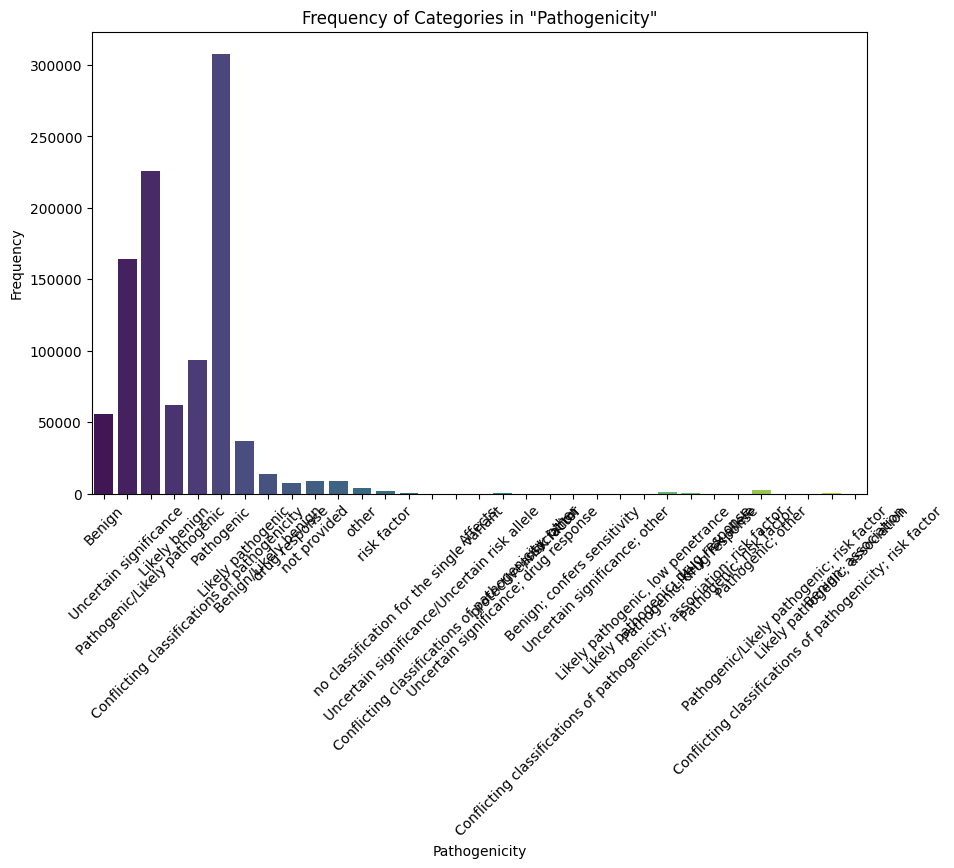

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Pathogenicity', data=merged_df, palette='viridis')

# Add labels and title
plt.xlabel('Pathogenicity')
plt.ylabel('Frequency')
plt.title('Frequency of Categories in "Pathogenicity"')

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
category = 'Benign/Likely benign'
category_freq = merged_df['Pathogenicity'].value_counts().get(category, 0)
print(f"Frequency of '{category}': {category_freq}")

Frequency of 'Benign/Likely benign': 13445


In [ ]:
category_counts = merged_df['Pathogenicity'].value_counts()
valid_categories = category_counts[category_counts >= 10000].index
filtered_df = merged_df[merged_df['Pathogenicity'].isin(valid_categories)]
print(filtered_df.shape)

(959952, 18)


In [ ]:
category_mapping = {
    'Benign': 'Benign',
    'Likely benign': 'Benign',
    'Benign/Likely benign': 'Benign',
    'Pathogenic': 'Pathogenic',
    'Likely pathogenic': 'Pathogenic',
    'Pathogenic/Likely pathogenic': 'Pathogenic',
    'Uncertain significance': 'Uncertain',
    'Conflicting classifications of pathogenicity': 'Uncertain'
}

# Apply the mapping to the 'Pathogenicity' column
filtered_df['Pathogenicity'] = filtered_df['Pathogenicity'].map(category_mapping)

<ipython-input-59-88c3509d62a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Pathogenicity'] = filtered_df['Pathogenicity'].map(category_mapping)


<ipython-input-60-22235fc6c8a0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Pathogenicity', data=filtered_df, palette='viridis')


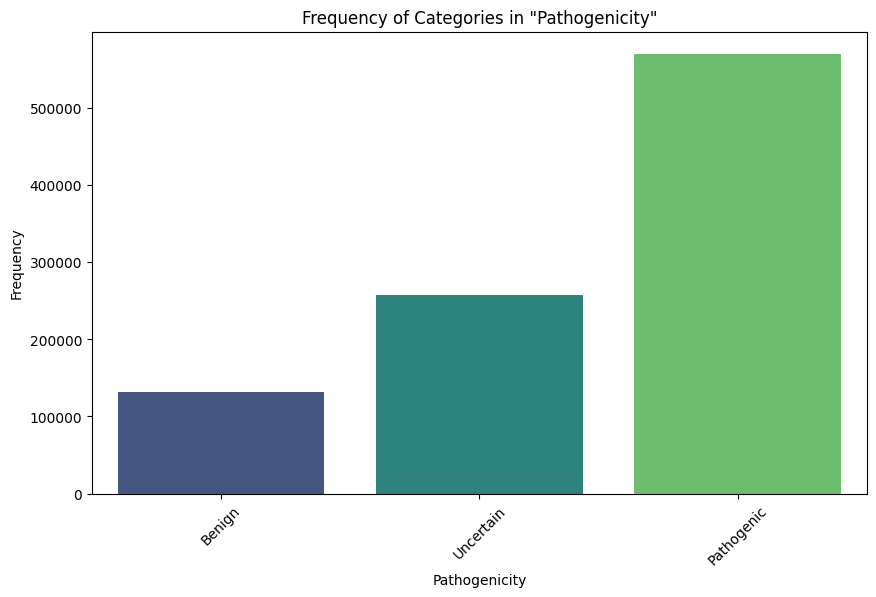

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Pathogenicity', data=filtered_df, palette='viridis')

# Add labels and title
plt.xlabel('Pathogenicity')
plt.ylabel('Frequency')
plt.title('Frequency of Categories in "Pathogenicity"')

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
filtered_df.head()

,GENE_SYMBOL,MUTATION_CDS,MUTATION_AA,MUTATION_DESCRIPTION,MUTATION_ZYGOSITY,MUTATION_SOMATIC_STATUS,CHROMOSOME,GENOME_START,GENOME_STOP,GENOMIC_WT_ALLELE,GENOMIC_MUT_ALLELE,LOH,PUBMED_PMID,STRAND,Pathogenicity,BLOSUM62_Score,Hydrophobicity_Change,Charge_Change
0,LZTR1,c.2219+13C>T,p.?,intron_variant,NaN,Variant of unknown origin,22,21350414,21350414,C,T,NaN,28713588.0,+,Benign,NaN,NaN,NaN
1,LZTR1,c.2219+60A>G,p.?,intron_variant,NaN,Reported in another cancer sample as somatic,22,21350461,21350461,A,G,NaN,28713588.0,+,Benign,NaN,NaN,NaN
2,LZTR1,c.2220-105T>C,p.?,intron_variant,NaN,Reported in another cancer sample as somatic,22,21350880,21350880,T,C,NaN,28713588.0,+,Benign,NaN,NaN,NaN
3,LZTR1,c.1200G>A,p.M400I,missense_variant,NaN,Confirmed somatic variant,22,21347133,21347133,G,A,NaN,26168399.0,+,Uncertain,1.0,2.6,0.0
4,LZTR1,c.1200G>A,p.M400I,missense_variant,NaN,Confirmed somatic variant,22,21347133,21347133,G,A,NaN,26168399.0,+,Uncertain,1.0,2.6,0.0


In [ ]:
filtered_df.to_csv("cosmic_clinvar.tsv", sep="\t", index=False)